
 enter a year between 2020 and 2070
prediction year: 2070

 enter a state
state: ma

 enter one of the avilable cities/towns for the state of  Massachusetts
['Worcester', 'Milton', 'Boston']
city/town: worcester

 enter the parameter to compare: "temperature", "percipitation", or "both"
parameter: both

 Worcester, Massachusetts 01524 in 2070 will be similar to  Belvidere, New Jersey 07823 in 2020


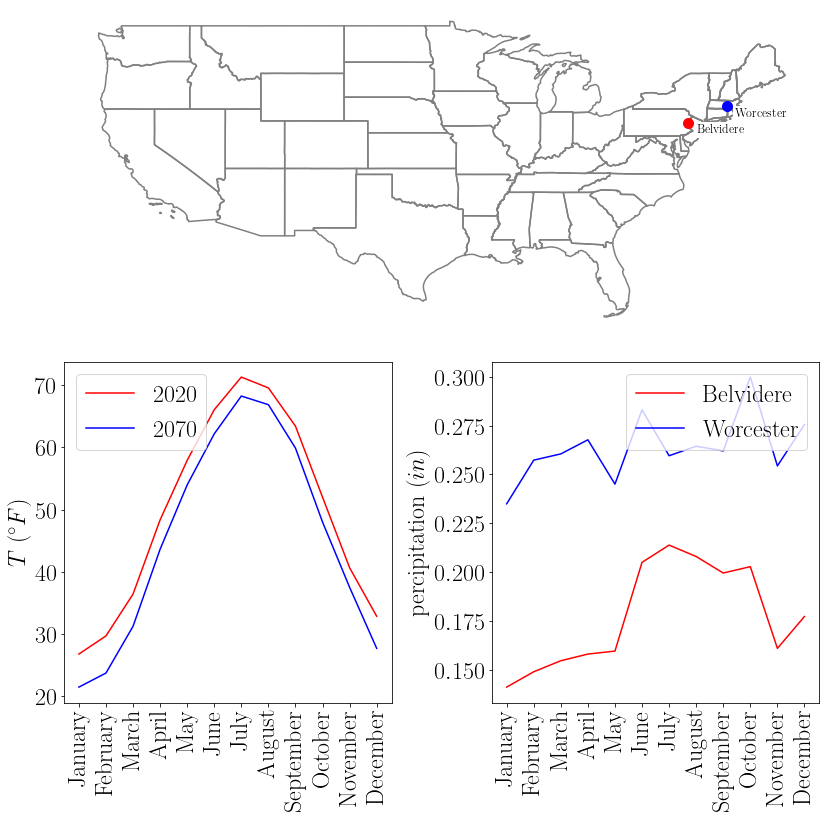

In [1]:
#####  Step 1: import modules and define paramaters ###########################
import geopandas
import geopy
import h5py
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from termcolor import colored
import us


# plot properties
LW = 5                 # line width
FS = 24                # font size
FN = 'times new roman' # font name

font = {'family':'serif', 'size':FS}
plt.rc('text', usetex=True) 
plt.rc('font', **font)
################################################################################


##### Step 2: load forecast data ################################################
# Us states geometries and data  
USmap = geopandas.read_file('usa-states-census-2014.shp')
citiesMaster = pd.read_csv('city_info_recent_all.csv')
nCities, _ = citiesMaster.shape
nMonths = 12


# p, d, q, P, D, Q, m: Seasonal ARIMA model parameters (i.e., 1, 1, 1, 1, 1, 1, 12)
p, d, q = 1, 1, 1  
P, D, Q, m = 1, 1, 1, 12

pars = ['ID', 'city', 'state', 'Lat', 'Lon', 'zipcode', 'tmean', 'prcp']
dates = pd.date_range('2020-01-01', '2070-12-01', freq='MS')
forecast = {}
hf = h5py.File('forecast_2020_2070.h5', 'r')
for ii in range(nCities): 
    cityID = citiesMaster['ID'][ii]
    forecast[cityID] = {}
    for jj in range(len(pars)-2):
        forecast[cityID][pars[jj]] = hf[citiesMaster['ID'][ii] + '/' + pars[jj]][()]
    for jj in range(6, len(pars)):
        temp = hf[citiesMaster['ID'][ii] + '/' + pars[jj]][()]
        forecast[cityID][pars[jj]] = pd.DataFrame(temp, index=dates, columns=[pars[jj]])
hf.close()
################################################################################


##### Step 3: choose date, state and city ######################################
print('\n enter a year between 2020 and 2070')

year = 0
while  year < 2020 or year > 2070:
    if year is not 0:
        print('date is out of range\n')
    year = int(input('prediction year: '))

    
print('\n enter a state')
state = 'AA'
while us.states.lookup(state) not in us.STATES:
    if state is not 'AA':
        print('state was not found\n')
    state = input("state: ") 
state = us.states.lookup(state).name

    
print('\n enter one of the avilable cities/towns for the state of ', state)
print(list(citiesMaster['city'][citiesMaster['state']==state]))
city = None
while city not in list(citiesMaster['city']):
    if city is not None:
        print('city was not found\n')
    city = input("city/town: ") 
    city = city.title() 
zipcode = citiesMaster['zipcode'][(citiesMaster['city']==city) & (citiesMaster['state']==state)].item()
futureID = citiesMaster['ID'][(citiesMaster['city']==city) & (citiesMaster['state']==state)].item()

factor = None
while factor not in ('temperature', 'percipitation', 'both'):
    if factor is not None:
        print('parameter was not found')
    print('\n enter the parameter to compare: "temperature", "percipitation", or "both"')
    factor = input('parameter: ')
################################################################################


##### Step 4: calculate the temperature and percipitation residuals ############
# and find the best match to "current" year ####################################
yearNow = 2020

Tfuture = forecast[futureID]['tmean'][str(year)]
Pfuture = forecast[futureID]['prcp'][str(year)]

months = Tfuture.index.strftime('%B')

Tresidual = np.zeros(nCities)
Presidual = np.zeros(nCities)
TPresidual = np.zeros(nCities)
for ii in range(nCities):
    ID = citiesMaster['ID'][ii]
    
    T = forecast[ID]['tmean'][str(yearNow)]
    Troot = pd.DataFrame((Tfuture.values - T.values)**2, columns=Tfuture.columns, index=Tfuture.index)
    Tresidual[ii] = np.sqrt(Troot.mean()).values/np.array(Tfuture.mean())
    
    P = forecast[ID]['prcp'][str(yearNow)]
    Proot = pd.DataFrame((Pfuture.values - P.values)**2, columns=Pfuture.columns, index=Pfuture.index)
    Presidual[ii] = np.sqrt(Proot.mean()).values/np.array(Pfuture.mean())
    
    TPresidual[ii] = 0.5*(Tresidual[ii] + Presidual[ii])


if factor == 'temperature':
    minInd = np.argmin(Tresidual)
elif factor == 'percipitation':
    minInd = np.argmin(Presidual)
else:  
    minInd = np.argmin(TPresidual)
    
nowID = citiesMaster['ID'][minInd]
Tnow = forecast[nowID]['tmean'][str(yearNow)]
Pnow = forecast[nowID]['prcp'][str(yearNow)]

print('\n', colored(city+ ', '+ state+ ' ' +str(zipcode).zfill(5)+' in '+ str(year), 'blue'), 
      'will be similar to ', 
      colored(forecast[nowID]['city']+ ', '+ forecast[nowID]['state']+ ' ' + str(forecast[nowID]['zipcode']).zfill(5)+' in '+ str(yearNow), 'red'))      

fig = plt.figure(figsize=(12, 12))
ax1 = fig.add_subplot(2, 2, (1,2))
USmap.boundary.plot(ax = ax1, color = 'gray')
plt.axis('off')
plt.plot(forecast[nowID]['Lon'], forecast[nowID]['Lat'], 'o', color = 'red', markersize = 10)
plt.plot(forecast[futureID]['Lon'], forecast[futureID]['Lat'], 'o', color = 'blue', markersize = 10)
x1 = forecast[nowID]['Lon']
y1 = forecast[nowID]['Lat']
x2 = forecast[futureID]['Lon']
y2 = forecast[futureID]['Lat']
dx = x2-x1
dy = y2-y1
plt.annotate(city, (0.99*x2, 0.98*y2), backgroundcolor='w', fontsize = 0.5*FS, xycoords='data')
plt.annotate(forecast[nowID]['city'] , (0.99*x1, 0.98*y1), backgroundcolor='w', fontsize = 0.5*FS, xycoords='data')

ax2 = fig.add_subplot(2, 2, 3)
plt.plot(np.arange(nMonths), np.array(Tnow), label = str(yearNow), color='red')
plt.plot(np.arange(nMonths), np.array(Tfuture), label = str(year), color='blue')
plt.legend(loc='upper left')
plt.ylabel('$T$ ($^\circ F$)')
plt.xticks(np.arange(nMonths), months, rotation='vertical')

ax3 = fig.add_subplot(2, 2, 4)
plt.plot(np.arange(nMonths), np.array(Pnow), label = forecast[nowID]['city'], color='red')
plt.plot(np.arange(nMonths), np.array(Pfuture), label = forecast[futureID]['city'], color='blue')
plt.legend(loc='upper right')
plt.ylabel('percipitation ($in$)')
plt.xticks(np.arange(nMonths), months, rotation='vertical')

plt.tight_layout()
plt.show()
################################################################################